In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import os 
import seaborn as sns
import glob
import natsort

In [2]:
import seaborn as sns
import copy

def load_data(save_path):
    datas = list()
    path_list = glob.glob(save_path)
    path_list = natsort.natsorted(path_list)
    data_temp = get_concat_glob(path_list)
    data_temp["a1"] = data_temp["a1"] * 100
    data_temp["a3"] = data_temp["a3"] * 100
    data_temp['Distribution'] = data_temp['distribution'] .map({0: "IID Label Distribution", 
                                                                0.3: "Non-IID Label Distribution",
                                                                0.5: "Non-IID Label Distribution"})
    return data_temp

In [3]:
def get_concat_glob(paths):
    data_ = []
    for i, path in enumerate(paths):


        # =====================================
        if "GGU" in path: continue
        if "GU112" in path: continue
        if "GU211" in path: continue

        # if "EP10" not in path: continue
        # =====================================

       
        data = pd.read_csv(path)
        data["Mode"] = data["mode"]
        data["Scaling"] = "Vanilla"
        data["GU_ratio"] = 0
        data["n_epochs"] = 5

        if "Output_GU" in path and "_GU111" in path and "LR" in path and "TIN" not in path:
            data["Scaling"] = "GU" + path.split("Output_GU")[1].split("_GU")[1].split("/")[0] 
            continue
        elif "_GU111" in path: 
            try:
                number = float(path.split("Output_GU")[1].split("_GU")[1][:6])
            except:
                number = float(path.split("Output_GU")[1].split("_GU")[1][:5])
            if "C100" in path:
                data["GU_ratio"] = (number - 111) * 10 
            elif "C10" in path:
                data["GU_ratio"] = (number - 111) * 5 
            elif "TIN" in path:
                # print(number)
                data["GU_ratio"] = (number - 111) * 6
            data["Scaling"] = "GU" + str(number)

        if "EP10" in path: data["n_epochs"] = 10
        
        if len(data_) == 0: data_ = data
        else: data_ = pd.concat([data_, data])
    return data_

## BarPlot

In [4]:
data_c100 = load_data("../Output_GU_C100/CIFAR100-*-N100-*/s[1-9].csv")   
data_c10  = load_data("../Output_GU_C10_M9/CIFAR10-*-N100-*/s[1-9].csv")
data_tin  = load_data("../Output_GU_TIN/TinyImageNet-*-N100-*/s[1-9].csv")


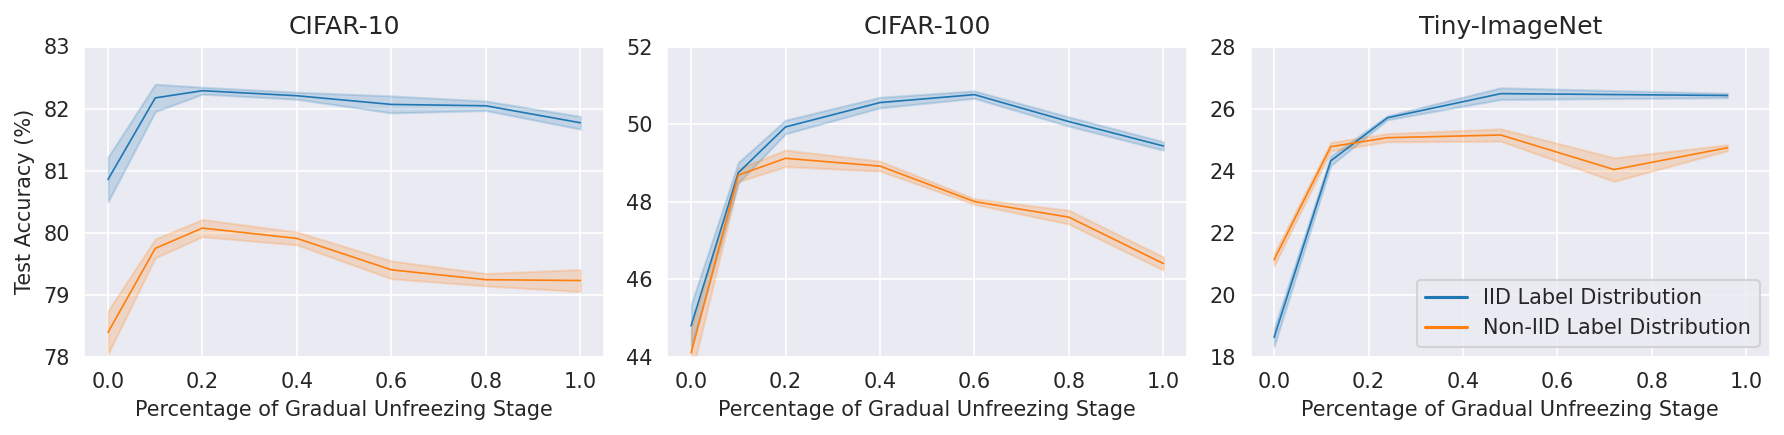

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=150, sharex=True)
sns.set_style("darkgrid")
for index, task, data_temp, title  in zip(range(3), ["Cifar10", "Cifar100", "TIN"], [data_c10, data_c100, data_tin], ["CIFAR-10", "CIFAR-100", "Tiny-ImageNet"]):
    ax = axes[index]
    temp = copy.deepcopy(data_temp)
    temp = temp[temp["act_prob"] == 0.01]
    if index == 0: temp = temp[temp["n_epochs"] == 10]
    elif index in [1,2]: temp = temp[temp["n_epochs"] == 5]
    if   index in [0]: temp = temp[(temp["epoch"] == 599)]
    elif index in [1]: temp = temp[(temp["epoch"] == 599)]
    elif index in [2]: temp = temp[(temp["epoch"] == 399)]
    temp = temp[(temp["mode"] == "fedavg")]
    ax = sns.lineplot(data=temp, x="GU_ratio", y="a3", hue="Distribution", ax=ax, errorbar="se", linewidth = 0.8)
    ax.set_title(title)

axes[0].set_ylabel("Test Accuracy (%)"), axes[1].set_ylabel(""), axes[2].set_ylabel("")
axes[0].set_ylim([78,83]), axes[1].set_ylim([44,52]), axes[2].set_ylim([18,28])
axes[0].get_legend().remove(), axes[1].get_legend().remove(), axes[2].legend(loc=4, prop={'size': 10})
for ax in axes.flatten(): ax.set_xlabel("Percentage of Gradual Unfreezing Stage")
fig.tight_layout() 
plt.savefig("../SaveFig/exp_ablation_gu_percentage.pdf")
plt.pause(0.1)